# Classifying Student Knowledge Levels Using Metrics of Academic Rigor

DSCI 100 010 W2023T2, Group 01 (Thomas Hesselbo, Debon Lee, Coe McGrath, Celine Xi)

### Introduction

Being able to predict a given student’s knowledge level in a given subject is of pedagogical importance, as it would allow an instructor to identify students who are in need of additional assistance. Subsequently, our project has built a classifier to identify a student’s level of knowledge utilizing their performance and their study habits in a current subject and its prerequisite subjects. To accomplish this, our project used the “User Knowledge Modeling” dataset sourced from the UC Irvine Machine Learning Repository. This data set contains the variables STG, SCG, STR, LPR, PEG, and UNS. User knowledge (UNS) is classified as either “very low”, “low”, “middle”, or “high”. STG and STR are the normalized study times for current material and prerequisite material respectively. PEG is performance on exams for the current subject. SCG is the extent of repetition undergone by that student for the current subject. Finally, LPR is the student’s knowledge in the prerequisite courses. These variables (STG, SCG, STR, LPR, PEG) are normalized and scaled from 0 to 1, and come pre-split into training and test data sets. 

### Preliminary Data Exploration

#### Loading Packages and setting the environment

Here, we are using the library() function to load the libraries containing the necessary functions to carry out the data analysis. This includes installing the package for the “themis” library as it is not already installed on the server and contains the functions required to upscale the data. Finally, we use the options function to limit the amount of rows displayable by a printed data frame to 6.

In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
library(readxl)
library(RColorBrewer)

install.packages("themis")
library(themis)
options(repr.matrix.max.rows = 6)

Warning message:
“package ‘ggplot2’ was built under R version 4.3.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_co

#### Loading the Excel Data

To load the project data, we first created a temporary file. We then downloaded the excel into that temporary file. Because the data is already split into training and testing data, we then read specific pages of the excel file to create data frames for the testing and the training. 

In [2]:
url <- "https://github.com/TheABoss/DSCI-100-2023T2-Project-Group-001/raw/main/data/Data_User_Modeling_Dataset_Hamdi%20Tolga%20KAHRAMAN.xls"
#Define URL object for Excel dataset

temp_xls <- tempfile(fileext = ".xls")
#Prepare temp file

download.file(url, destfile = temp_xls)
#Downloading Excel file

know_train_raw <- read_excel(temp_xls,sheet = 2,range = "A1:F259")
#Downloading Excel sheet as tibble containing training data

know_test_raw <- read_excel(temp_xls,sheet = 3,range = "A1:F146")
#Downloading Excel sheet as tibble containing test data

#### Data Previewing, Cleaning, And wrangling

To clean the data, we first adjusted some of the naming. Because “very_low” and “Very Low” were used interchangeably in the data sets, we first replaced all instances of “very_low” with “Very Low” in both data sets. Then, because the UNS column was a “character” class, we converted it to a factor, and reordered the factors such that they would be equivalent across both the testing and training data sets. Finally, to preview the data we then printed the first 3 and last 3 rows of each data set using options(repr.matrix.max.rows = 6). We also checked for NAs in either data set (of which there are none).


In [3]:
#converting target class (UNS) to factor  
know_train_raw$UNS <- replace(know_train_raw$UNS, know_train_raw$UNS == "very_low", "Very Low")
# Miss-match bettween the exact string used to signify very low bettween test and training,
# This line standardizes it to be "Very Low" in both

know_train <- know_train_raw |>
                mutate(UNS = factor(UNS, levels = c("Very Low", "Low", "Middle", "High")))

know_test_raw$UNS <- replace(know_test_raw$UNS, know_test_raw$UNS == "very_low", "Very Low")
# Miss-match bettween the exact string used to signify very low bettween test and training,
# This line standardizes it to be "Very Low" in both
know_test <- know_test_raw |>
                mutate(UNS = factor(UNS, levels = c("Very Low", "Low", "Middle", "High")))
know_train
know_test

any(is.na(know_train))
any(is.na(know_test))
#Checking for NAs

STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.00,0.00,0.00,0.00,0.00,Very Low
0.08,0.08,0.10,0.24,0.90,High
0.06,0.06,0.05,0.25,0.33,Low
⋮,⋮,⋮,⋮,⋮,⋮
0.54,0.82,0.71,0.29,0.77,High
0.50,0.75,0.81,0.61,0.26,Middle
0.66,0.90,0.76,0.87,0.74,High


STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.00,0.10,0.50,0.26,0.05,Very Low
0.05,0.05,0.55,0.60,0.14,Low
0.08,0.18,0.63,0.60,0.85,High
⋮,⋮,⋮,⋮,⋮,⋮
0.56,0.60,0.77,0.13,0.32,Low
0.66,0.68,0.81,0.57,0.57,Middle
0.68,0.64,0.79,0.97,0.24,Middle


[1] FALSE

[1] FALSE

Other than the above adjustments, the loaded data meets the prerequisites of being tidy (rows = single observations, columns = single variables, one cell = one value). Thus, no cleaning or wrangling was performed as the data is already tidy.

### Data Summary

#### Summary Table

To create this table, we utilized the “group_by” and “summarize” functions to calculate the mean value of the different categories at their respective knowledge level (using the mean() function) and the number of observations (using the n() function).

In [4]:
know_train_avg <- know_train |>
                group_by(UNS) |>
                summarize(avgSTG = mean(STG),
                      avgSCG = mean(SCG),
                      avgSTR = mean(STR),
                      avgLPR = mean(LPR),
                      avgPEG = mean(PEG),
                      Observations = n()) |>
                arrange(desc(avgSTG))
know_train_avg

UNS,avgSTG,avgSCG,avgSTR,avgLPR,avgPEG,Observations
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
High,0.4216508,0.4231905,0.5016667,0.5012698,0.77253968,63
Middle,0.3999773,0.3679205,0.5068182,0.3428409,0.54238636,88
Low,0.3211446,0.3370000,0.4307229,0.4973494,0.23762651,83
Very Low,0.3057917,0.1981250,0.3662500,0.3587500,0.09083333,24


This table shows how the mean of each of the variables changes depending on the knowledge level of the user 

#### Data Summary Plots

To create the graphs, first the pivot longer function was used to make the data more easily readable by ggplot. Then, the ggplot was used to create a graph representing the Data summary table in the form of a bar graph, and a separate graph was also created using a facet grid to display the distribution via histogram of the different variables across the different levels.

In [5]:
reorder <- know_train |>
            pivot_longer(STG:PEG, names_to = "type", values_to = "value") |>
            group_by(UNS,type) |>
            summarise(avg = mean(value),
                      sd = sd(value))
#Pivoting summmary table such that it is easily readable by ggplot

#reorder$UNS <- factor(reorder$UNS, levels = c("very_low", "Low", "Middle", "High"))
#Reorder data from V. Low to High, while also including human-readable labels

options(repr.plot.width = 10, repr.plot.height = 7)
know_train_avg_plot <- ggplot(reorder, aes(x = UNS, 
                                           y = avg, 
                                           fill = UNS)) +
                        geom_bar(stat = "identity", 
                                 position = "dodge") +
                        labs(x = "Knowledge Level", 
                             y = "Scaled Performance", 
                             title = "Average Scaled Performance with\n Respect to Knowledge Level and Attribute",
                             fill = "Knowledge Level") +
                        facet_grid(. ~ type) + 
                        scale_x_discrete(labels = c("Very Low", 
                                                    "Low", 
                                                    "Middle", 
                                                    "High")) +
                        scale_fill_brewer(palette = "Paired", 
                                          labels = c("Very Low", 
                                                    "Low", 
                                                    "Middle", 
                                                    "High")) +
                        theme(text = element_text(size = 16), 
                              axis.text.x = element_text(angle = 50, hjust = 1))

reorderhist <- know_train |>
            pivot_longer(STG:PEG, names_to = "type", values_to = "value")

#reorderhist$UNS <- factor(reorderhist$UNS, levels = c("very_low", "Low", "Middle", "High"))

know_train_hist_plot <- ggplot(reorderhist, aes(x = value, 
                                           fill = UNS)) +
                        geom_histogram() +
                        labs(x = "Knowledge Level", 
                             y = "Scaled Performance", 
                             title = "Average Scaled Performance with\n Respect to Knowledge Level and Attribute",
                             fill = "Knowledge Level") +
                        facet_grid(rows = vars(type), cols = vars(UNS)) +
                        scale_fill_brewer(palette = "Paired",
                                          labels = c("Very Low", 
                                                    "Low", 
                                                    "Middle", 
                                                    "High")) +
                        theme(text = element_text(size = 16), 
                              axis.text.x = element_text(angle = 50, hjust = 1))


`summarise()` has grouped output by 'UNS'. You can override using the `.groups`
argument.


Figure 1: Average Scaled Performance with respect to Knowledge Level and Attribute

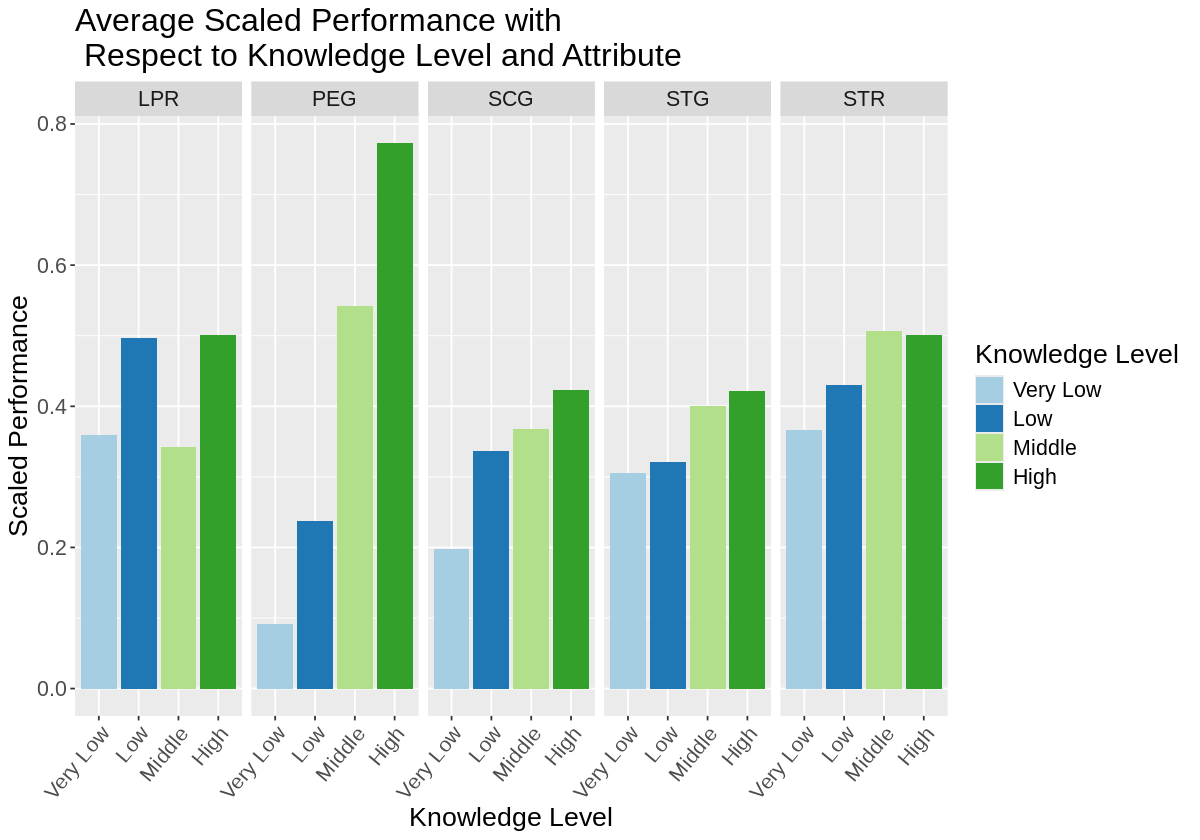

In [6]:
know_train_avg_plot

Figure 2: Average Scaled Performance with\n Respect to Knowledge Level and Attribute

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


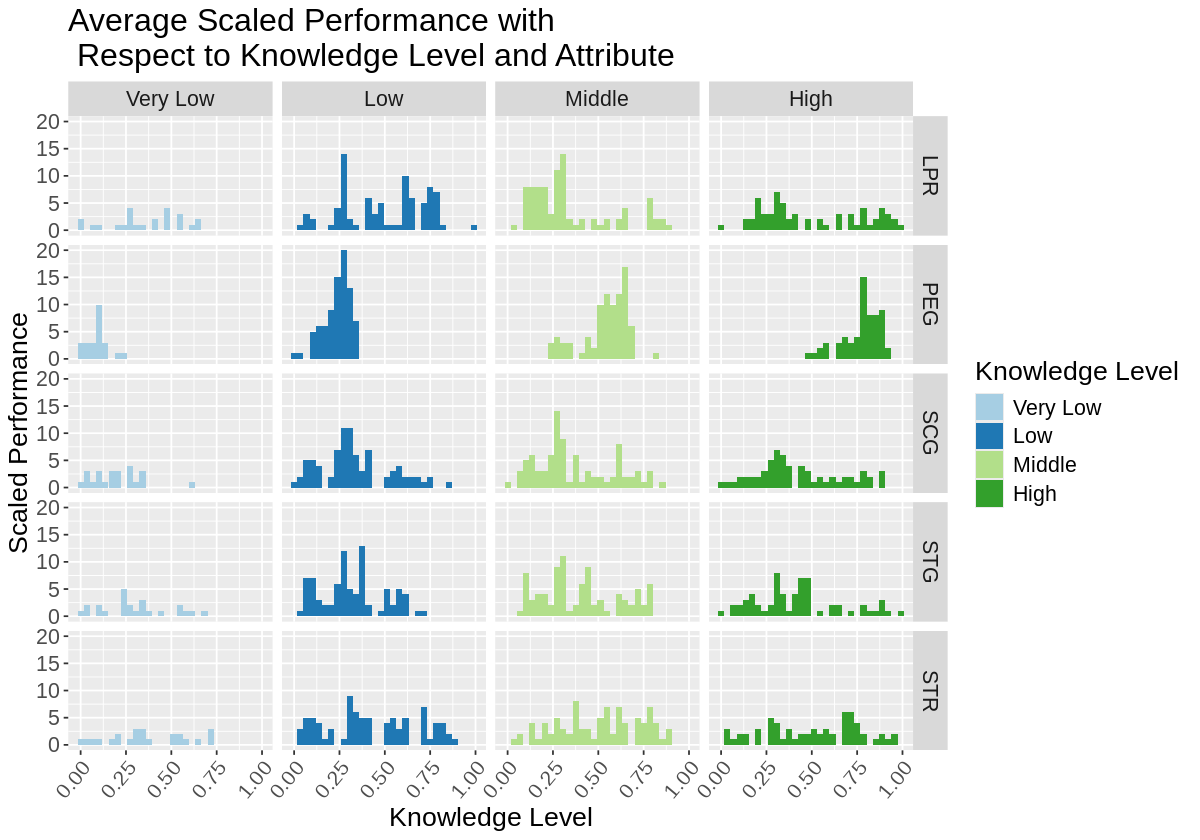

In [7]:
know_train_hist_plot

### Building the data model

#### Upsampling the data

Here, we prepped a recipe that upscales the data using the step_upscale function from the themis package.

In [8]:
ups_recipe <- recipe(UNS ~., data = know_train) |>
                step_upsample(UNS, over_ratio = 1, skip = FALSE) |>
                prep()


know_train <- bake(ups_recipe, know_train)


Upscaling the data is done as there are significantly fewer observations of “Very low” compared with the rest of the observations (24 vs 88,84,63 that we can see in the data summary graph).

#### Creating Recipe and tune model

Here, we created the recipe by using the recipe function, and setting the predictors for UNS as PEG and SCG. The recipe also scales and centers the predictors using step_scale() and step_center(). We also set the model here, using the nearest_neighbour model to create a model that tunes the k value, with a kknn engine set for classification and a rectangular weight function.

In [41]:
recipe <- recipe(UNS ~ PEG + SCG, data = know_train) |>
#STR and STG
            step_scale(all_predictors()) |>
            step_center(all_predictors())

kspec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
        set_engine("kknn") |>
        set_mode("classification")


#### Finding the best K

In [48]:
set.seed(2077)
vfold <- vfold_cv(know_train, v = 20, strata = UNS)
k_vals <- tibble(neighbors = seq(from = 1, to = 50, by = 1))

k_results <- workflow() |>
         add_recipe(recipe) |>
         add_model(kspec) |>
         tune_grid(resamples = vfold, grid = k_vals)|>
         collect_metrics()

k_results

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.904375,20,0.013150039,Preprocessor1_Model01
1,roc_auc,hand_till,0.936250,20,0.008766693,Preprocessor1_Model01
2,accuracy,multiclass,0.898750,20,0.012331096,Preprocessor1_Model02
⋮,⋮,⋮,⋮,⋮,⋮,⋮
49,roc_auc,hand_till,0.9557865,20,0.007735245,Preprocessor1_Model49
50,accuracy,multiclass,0.8106250,20,0.021788362,Preprocessor1_Model50
50,roc_auc,hand_till,0.9548854,20,0.007707096,Preprocessor1_Model50


#### Best K Graph

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.904375,20,0.01315004,Preprocessor1_Model01
2,accuracy,multiclass,0.898750,20,0.01233110,Preprocessor1_Model02
3,accuracy,multiclass,0.854375,20,0.01605078,Preprocessor1_Model03
4,accuracy,multiclass,0.854375,20,0.01605078,Preprocessor1_Model04
22,accuracy,multiclass,0.843750,20,0.02050955,Preprocessor1_Model22
5,accuracy,multiclass,0.841875,20,0.01889799,Preprocessor1_Model05


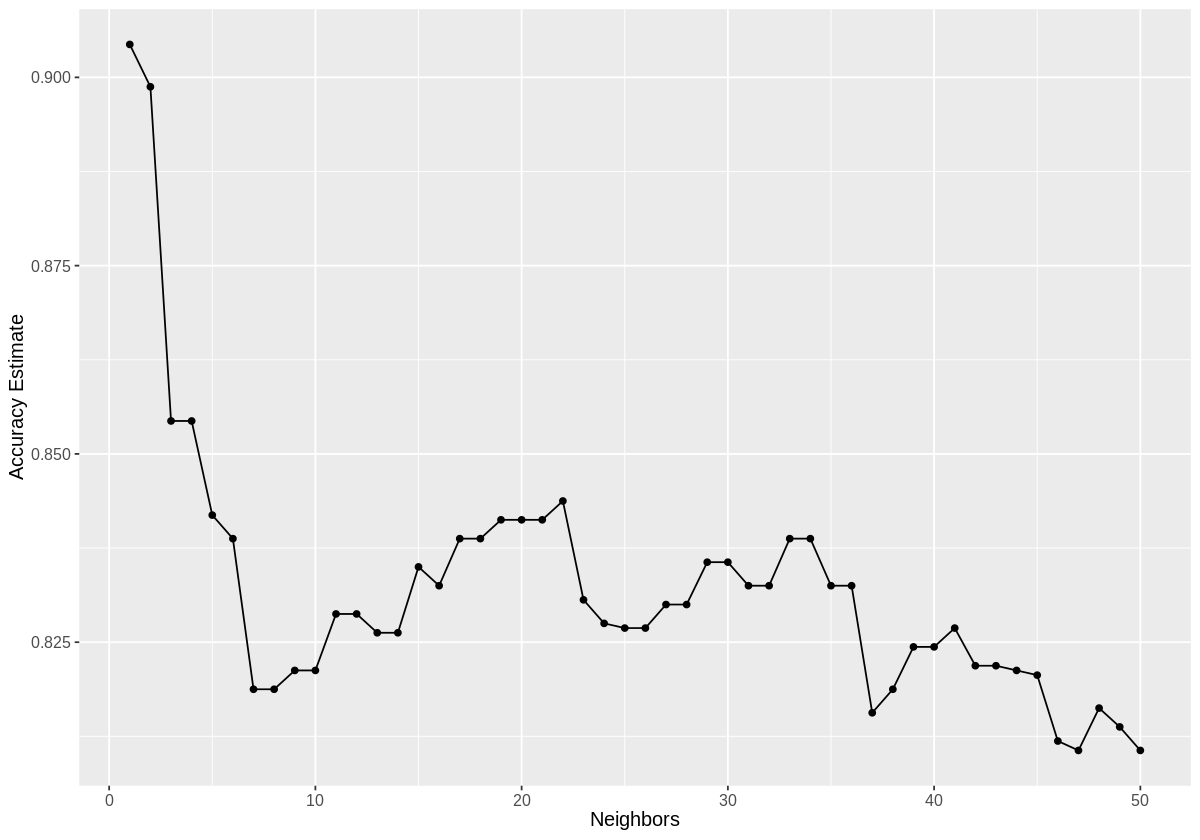

In [49]:
set.seed(2077)
accuracies <- k_results |>
              filter(.metric == "accuracy")

kplot <- ggplot(data = accuracies, aes(x = neighbors,y = mean)) +
                geom_point() +
                geom_line() +
                labs(x = "Neighbors",
                     y = "Accuracy Estimate") +
                theme(text = element_text(size = 12))
# Generating best plot


best_k <- accuracies |>
    arrange(desc(mean)) |>
    head(6)
# Printing best K 

kplot
best_k

#### We can see Best k at = 21, as it has the highest accuracy while avoiding using k=1, as that would cause over fitting

#### Creating Best model

In [50]:
knn_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 22)|>
                set_engine("kknn") |>
                set_mode("classification")

knn_best_fit <- workflow() |>
                add_recipe(recipe) |>
                add_model(knn_best_spec) |>
                fit(data = know_train)

#### Assessing model accuracy (set up)

In [51]:
knn_predictions <- predict(knn_best_fit, know_test) |>
                    bind_cols(know_test)
knn_predictions

.pred_class,STG,SCG,STR,LPR,PEG,UNS
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
Very Low,0.00,0.10,0.50,0.26,0.05,Very Low
Very Low,0.05,0.05,0.55,0.60,0.14,Low
High,0.08,0.18,0.63,0.60,0.85,High
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Low,0.56,0.60,0.77,0.13,0.32,Low
Middle,0.66,0.68,0.81,0.57,0.57,Middle
Low,0.68,0.64,0.79,0.97,0.24,Middle


In [52]:
knn_predictions |>
                    metrics(truth = UNS, estimate = .pred_class) |>
                    filter(.metric == "accuracy")

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.8068966


#### Confusion matrix

In [53]:
conf <- knn_predictions |>
        conf_mat(truth = UNS, estimate = .pred_class)

conf

          Truth
Prediction Very Low Low Middle High
  Very Low       15   3      0    0
  Low            11  43     10    0
  Middle          0   0     23    3
  High            0   0      1   36